# Delineating the transcriptional boost on single-cell resolution in gastrulation erythroid maturation

This tutorial shows how cellDancer analyzes RNA velocity. The process includes (1) estimating RNA velocity, (2) deriving cell fates on embedding space, and (3) estimating pseudotime.
 
This tutorial also demonstrates cellDancer's ability to resolve the difficulty of predicting the velocity of genes with transcriptional boost mentioned by [Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y)

Below is the case study for gastrulation erythroid maturation. We select 12,329 cells with 2,000 genes from haemato-endothelial progenitors, blood progenitors 1/2, and erythroid 1/2/3. The embryonic days are selected from E7.0, E7.25, E7.5, E7.75, E8.0, E8.25, and E8.5.

## Import packages

To run the notebook locally, [Installation](installation.html) could be referred to install the environment and dependencies.

In [4]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

## Load data 

The input data for cellDancer contains the abundances of unspliced RNA and spliced RNA. For the detail of obtaining the dataset and pre-processing steps, [Data Preparation](data_preprocessing.html) could be referred to. We follow the standard data preparation procedures in [scVelo](https://scvelo.readthedocs.io/) with default parameters except that we use 100 nearest neighbors for first-moment calculation.

The data of gastrulation erythroid maturation could be downloaded and unzipped from [GastrulationErythroid_cell_type_u_s.csv.zip](https://drive.google.com/file/d/1DSbxJr5dh-NJp4Bx20tNlZHSjGjyigw-/view?usp=sharing). It could be loaded by ```pd.read_csv('your_path/GastrulationErythroid_cell_type_u_s.csv')```. To load your own data, the dataframe should contain columns 'gene_name', 'unsplice', 'splice' ,'cellID' ,'clusters' ,'embedding1' , and 'embedding2.' For a detailed description of the data structure, [Preprocessing](data_preprocessing.html) could be referred to.

In [5]:
cell_type_u_s_path='/Users/jenniferli/Downloads/CSCI 2952G/GastrulationErythroid_cell_type_u_s.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Sox17,0.000000,0.043971,cell_363,Blood progenitors 2,3.460521,15.574629
1,Sox17,0.000000,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734
2,Sox17,0.000000,0.018161,cell_385,Blood progenitors 2,2.351203,15.267069
3,Sox17,0.000000,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825
4,Sox17,0.000000,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,cell_139318,Erythroid3,8.032358,7.603037
24657996,Gm47283,0.300111,1.072944,cell_139321,Erythroid3,10.352904,6.446736
24657997,Gm47283,0.292607,1.199875,cell_139326,Erythroid3,9.464873,7.261099
24657998,Gm47283,0.266031,1.114659,cell_139327,Erythroid3,9.990495,7.243880


## Estimate RNA velocity for sample genes

 Here, 15 genes in ```gene_list``` are estimated as an example. The predicted unspliced and spliced reads, alpha, beta, and gamma are added to the dataframe.

In [6]:
gene_list=['Smarca2', 'Rbms2', 'Myo1b', 'Hba-x', 'Yipf5', 'Skap1', 'Smim1', 'Nfkb1', 'Sulf2', 'Blvrb', 'Hbb-y', 'Coro2b', 'Yipf5', 'Phc2', 'Mllt3']

loss_df, cellDancer_df=cd.velocity(cell_type_u_s,\
                                   gene_list=gene_list,\
                                   permutation_ratio=0.125,\
                                   n_jobs=8)
cellDancer_df

Using /Users/jenniferli/Downloads/CSCI 2952G/final_project/csci2592g-final-project/src/notebooks/cellDancer_velocity_2023-12-03 10-33-09 as the output path.
Arranging genes for parallel job.
14  genes were arranged to  2  portions.


,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Mllt3,0.087552,0.061677,0.131864,0.347319,0.264903,0.304851,0.335579,0.111875,cell_363,Blood progenitors 2,3.460521,15.574629
1,1,Mllt3,0.042049,0.056451,0.096471,0.192440,0.253070,0.303873,0.335266,0.111875,cell_382,Blood progenitors 2,2.490433,14.971734
2,2,Mllt3,0.046162,0.073611,0.099587,0.222645,0.253818,0.304017,0.335363,0.111875,cell_385,Blood progenitors 2,2.351203,15.267069
3,3,Mllt3,0.119952,0.142994,0.156111,0.534318,0.270146,0.306117,0.336443,0.111875,cell_393,Blood progenitors 2,5.899098,14.388825
4,4,Mllt3,0.027221,0.136220,0.083502,0.221573,0.243896,0.304314,0.336083,0.111875,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172601,12324,Yipf5,0.098889,0.443361,0.090468,0.466481,0.041808,0.205128,0.468360,0.066032,cell_139318,Erythroid3,8.032358,7.603037
172602,12325,Yipf5,0.092605,0.521375,0.084466,0.530024,0.037817,0.204039,0.470695,0.066032,cell_139321,Erythroid3,10.352904,6.446736
172603,12326,Yipf5,0.108367,0.443695,0.098418,0.473774,0.042915,0.204746,0.468353,0.066032,cell_139326,Erythroid3,9.464873,7.261099
172604,12327,Yipf5,0.067904,0.431785,0.064668,0.433252,0.038778,0.206518,0.468079,0.066032,cell_139327,Erythroid3,9.990495,7.243880


## Visualize the phase portraits

We visualize the phase portrait of each gene with ```cdplt.scatter_gene()```.

From the figures below, the prediction of those genes that have transcriptional boost (Hba-x, Smim1, and Hbb-y) are consistent with the progression of gastrulation erythroid maturation of (1) haemato-endothelial progenitors, (2) blood progenitors 1/2, and (3) erythroid. This reflects the ability of cellDancer to resolve the RNA velocity for the genes in the transcriptional boost scenario.

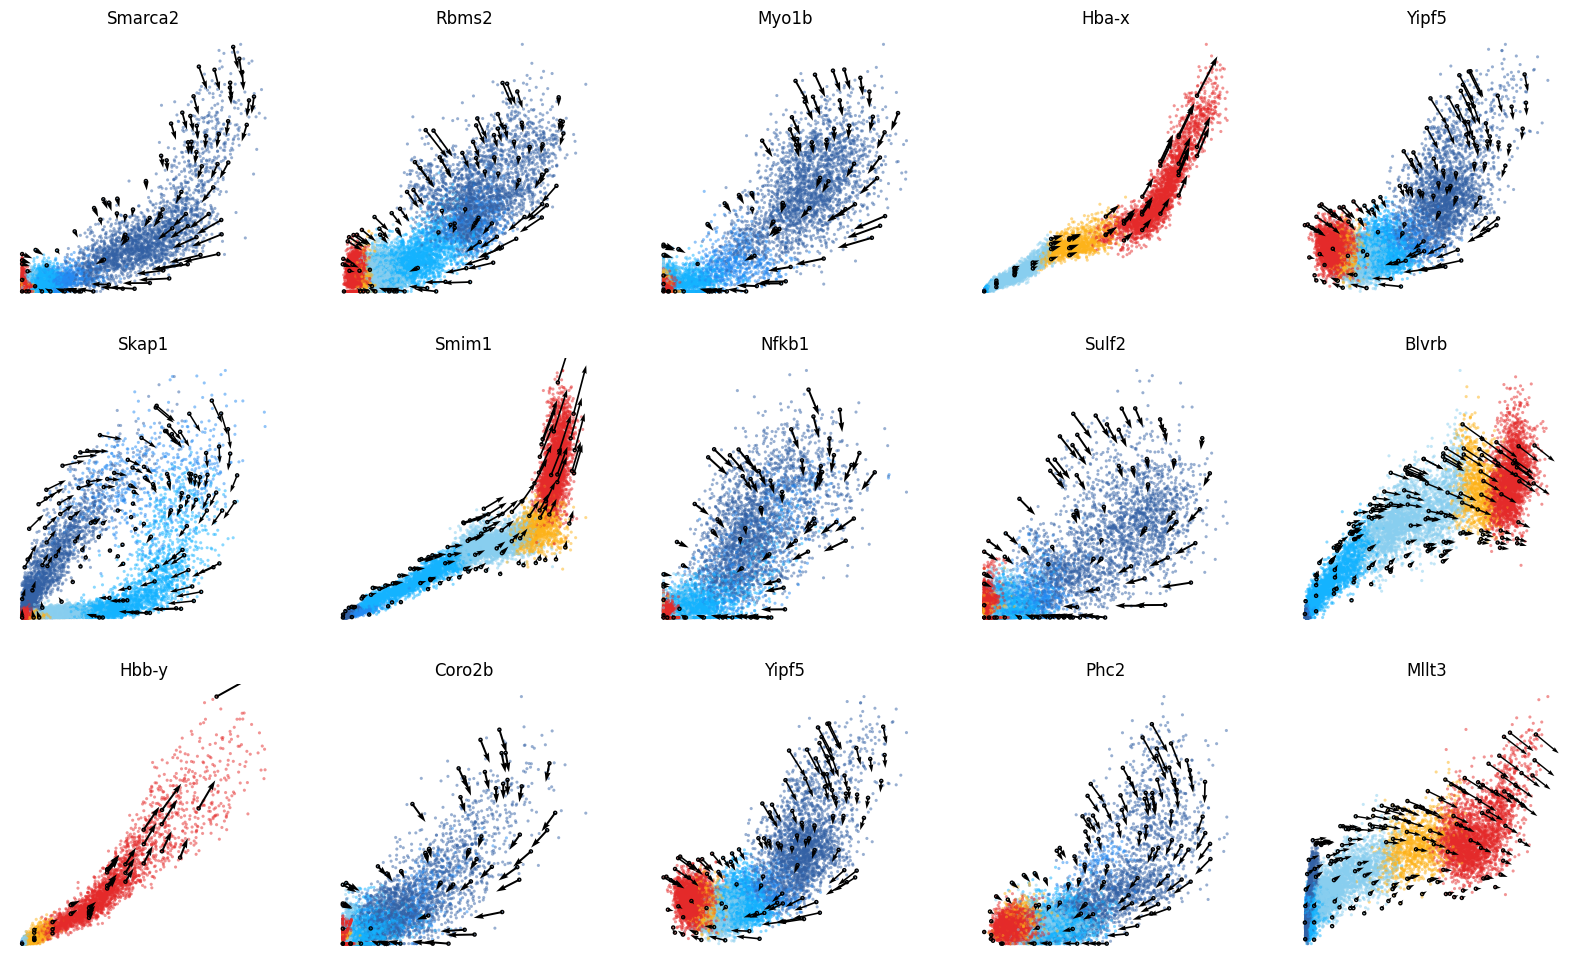

In [6]:
ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

## Project the RNA velocity onto the embedding space

To project the prediction of RNA velocity onto the embedding space and to estimate pseudotime using all 2,000 genes, predicted result can be downloaded from [GastrulationErythroid_cellDancer_estimation.csv.zip](https://drive.google.com/file/d/1J4GB-Bn2SdmK56wXka5TdvkImspPwIjH/view?usp=sharing)

In [7]:
# load the prediction result of all genes
cellDancer_df_path = 'your_path/GastrulationErythroid_cellDancer_estimation.csv'
cellDancer_df = pd.read_csv(cellDancer_df_path)

FileNotFoundError: [Errno 2] No such file or directory: 'your_path/GastrulationErythroid_cellDancer_estimation.csv'

We calculate the projection of RNA velocity on the embedding with ```cd.compute_cell_velocity()```. The projected direction on embedding space, i.e. columns 'velocity1' and 'velocity2' are added to the original dataframe. We use ```cdplt.scatter_cell()``` to display the predicted direction on embedding space.

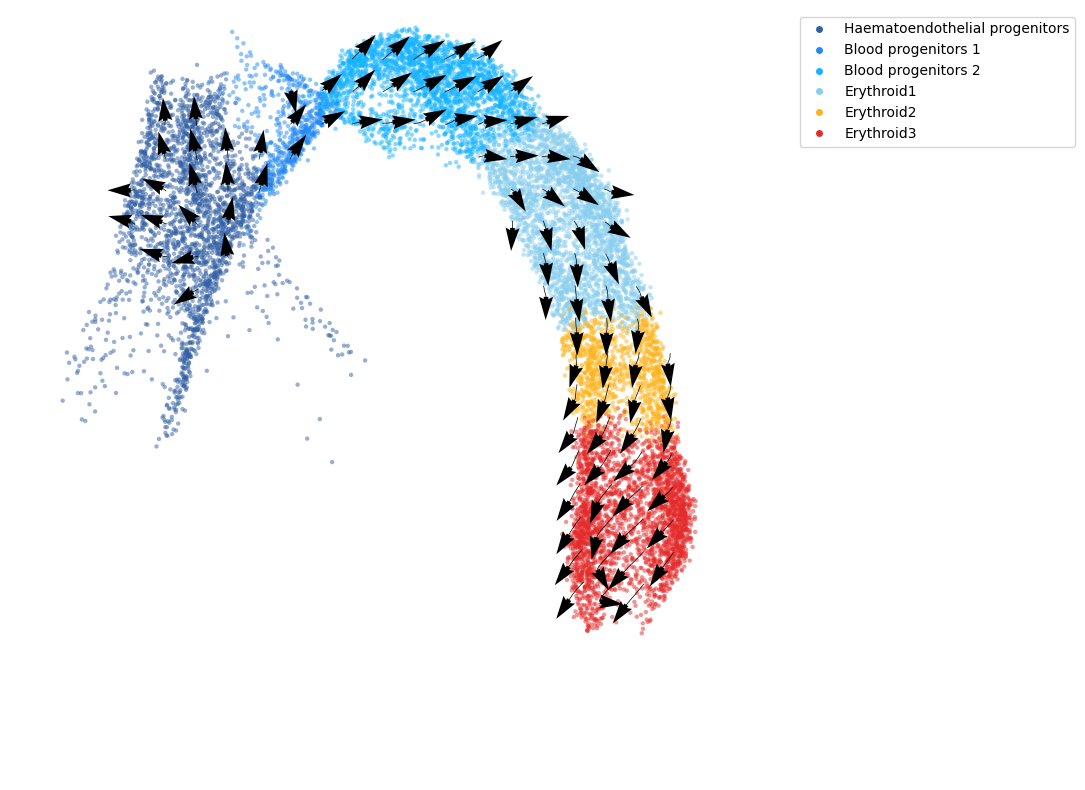

In [6]:
# compute cell velocity
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=10, speed_up=(100,100))

# plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
cdplt.scatter_cell(ax,
                   cellDancer_df,
                   colors=colormap.colormap_erythroid, 
                   alpha=0.5, 
                   s=10,
                   velocity=True,
                   legend='on',
                   min_mass=15,
                   arrow_grid=(20,20),
                   custom_xlim=[-6,13], 
                   custom_ylim=[2,16], )
ax.axis('off')
plt.show()

In [7]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Ift81,0.010658,0.026321,0.009261,0.029549,0.023595,0.042598,0.073999,0.039626,cell_363,Blood progenitors 2,3.460521,15.574629,0,NaN,NaN
1,1,Ift81,0.000000,0.044266,0.000946,0.037888,0.020649,0.042942,0.074502,0.039626,cell_382,Blood progenitors 2,2.490433,14.971734,1,NaN,NaN
2,2,Ift81,0.000000,0.064559,0.000885,0.055191,0.019326,0.042876,0.075031,0.039626,cell_385,Blood progenitors 2,2.351203,15.267069,2,NaN,NaN
3,3,Ift81,0.000000,0.020756,0.001014,0.017791,0.022149,0.043030,0.073879,0.039626,cell_393,Blood progenitors 2,5.899098,14.388825,3,NaN,NaN
4,4,Ift81,0.000000,0.013184,0.001037,0.011305,0.022633,0.043055,0.073676,0.039626,cell_398,Blood progenitors 2,4.823139,15.374831,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24657995,12324,Mcrip1,0.000000,1.128435,0.000157,1.125867,0.005920,0.038023,0.013131,0.051755,cell_139318,Erythroid3,8.032358,7.603037,12324,NaN,NaN
24657996,12325,Mcrip1,0.024356,0.970672,0.016090,1.428982,0.008338,0.037053,0.013950,0.051755,cell_139321,Erythroid3,10.352904,6.446736,12325,NaN,NaN
24657997,12326,Mcrip1,0.000000,0.899107,0.000175,0.897000,0.006575,0.037644,0.013522,0.051755,cell_139326,Erythroid3,9.464873,7.261099,12326,NaN,NaN
24657998,12327,Mcrip1,0.017375,1.398107,0.011387,1.729827,0.006885,0.037765,0.013271,0.051755,cell_139327,Erythroid3,9.990495,7.243880,12327,NaN,NaN


## Estimate pseudotime

Based on the projection of RNA velocity on embedding space, we estimate the pseudotime with ```cd.pseudo_time()```.

The long trajectories used for pseudotime dertermination are (optionally) shown. In this case, the three long trajectories are colored from light to dark according to their own unadjusted pseudotime. The cells are colored according to the long trajectories that are used for determination of the pseudotime of the cells. 

Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|████████████| 9510/9510 [00:02<00:00, 3175.15it/s]


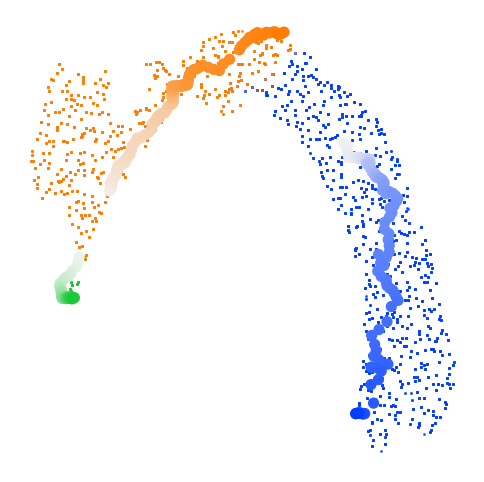

There are 3 clusters.
[0 1 2]
--- 257.67111110687256 seconds ---


In [8]:
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)} 
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df, 
                               grid=(30,30), 
                               dt=dt, 
                               t_total=t_total[dt], 
                               n_repeats=n_repeats, 
                               speed_up=(100,100),
                               n_paths = 3,
                               plot_long_trajs=True,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               n_jobs=8)

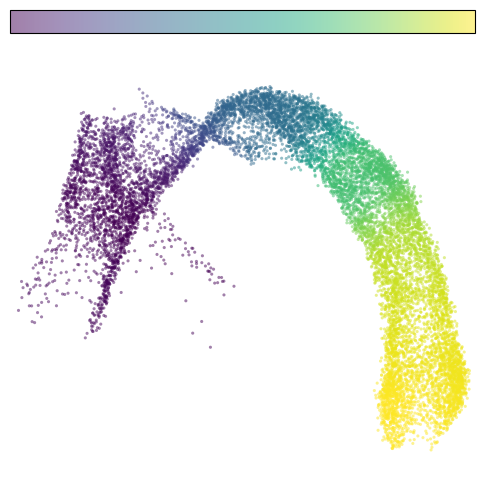

In [9]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, velocity=False, custom_xlim=(-5,11), custom_ylim=(4,18))
ax.axis('off')
plt.show()

The connection network below is another method to display pseudotime (```cdplt.PTO_Graph```). The edge lengths indicate the time difference between nodes (the closer in pseudotime, the shorter the edge length). The sizes of the nodes are proportional to the 
pseudotime.

<AxesSubplot:>

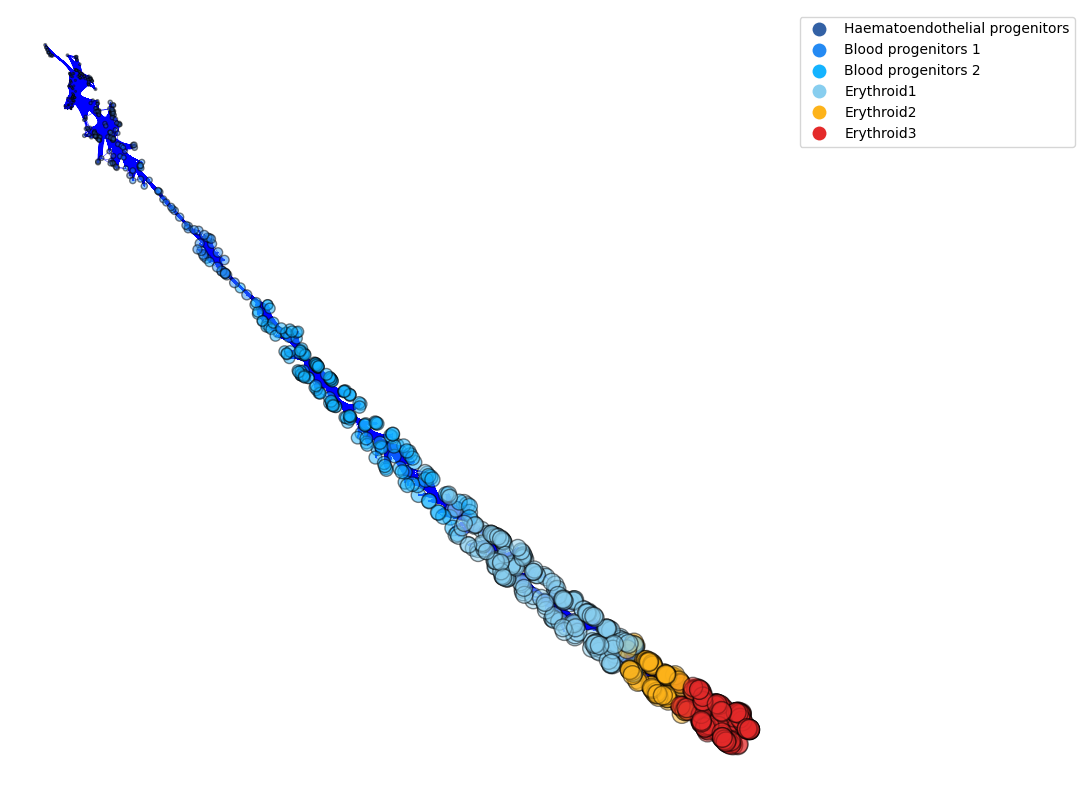

In [10]:
fig, ax= plt.subplots(figsize=(10,10))

cdplt.PTO_Graph(ax,
                cellDancer_df,
                node_layout='forcedirected',
                PRNG_SEED=10,
                use_edge_bundling=True,
                node_colors=colormap.colormap_erythroid,
                edge_length=3,
                node_sizes='pseudotime',
                colorbar='on',
                legend='on')

## Display the abundance of spliced RNA along pseudotime

We visualize the spliced RNA abundance of genes along pseudotime with ```cdplt.scatter_gene()```.

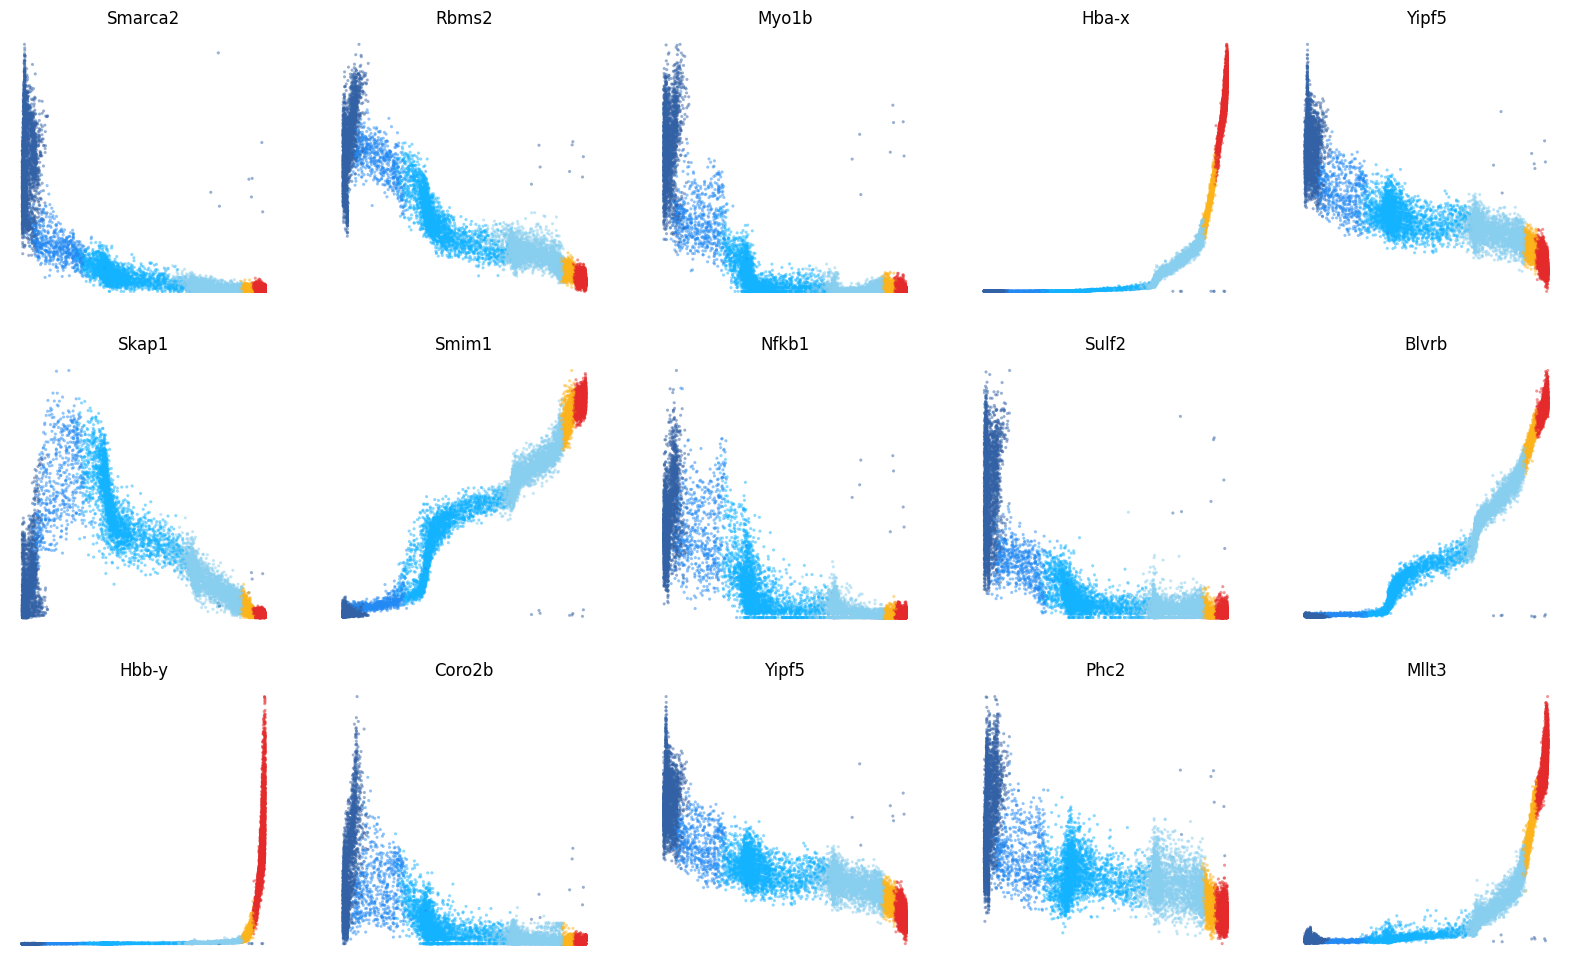

In [11]:
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

## Project the RNA velocity onto the embedding space for transcriptional boost genes

[Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y) identify MURK genes where the unspliced versus spliced slope in Late Erythroid is significantly higher than the slope in Mid Erythroid. These genes are incorrectly predicted using scVelo. Only after removing these genes, the projection of RNA velocity in embedding space is consistent with the progression of gastrulation erythroid maturation.

In the prediction result of cellDancer, we use MURK genes to project the RNA velocity on the embedding space. The projection of RNA velocity on the embedding space is consistent with the progression of gastrulation erythroid maturation. The MURK gene list could be obtained from [Additional file 3: Table S2](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-021-02414-y/MediaObjects/13059_2021_2414_MOESM3_ESM.csv) in the work of [Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y)

Caution! Overwriting the 'velocity' columns.


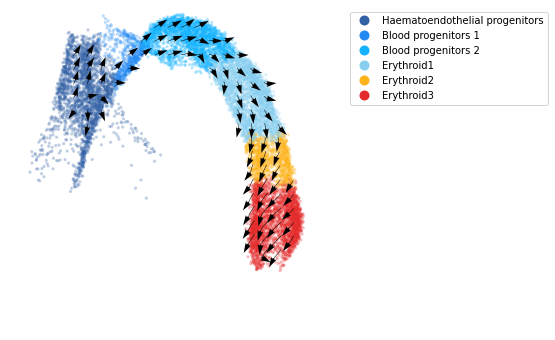

In [ ]:
# load MURK gene list
murk_gene_pd=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')
murk_gene_list=list(murk_gene_pd['index'])

# compute cell velocity
cellDancer_df_murk=cd.compute_cell_velocity(cellDancer_df=cellDancer_df,
                                            gene_list=murk_gene_list,
                                            projection_neighbor_choice='gene',
                                            expression_scale='power10',
                                            projection_neighbor_size=10,
                                            speed_up=(100,100))
# plot cell velocity
fig, ax = plt.subplots(figsize=(6,6))
im = cdplt.scatter_cell(ax,
                        cellDancer_df_murk, 
                        colors=colormap.colormap_erythroid, 
                        alpha=0.3, 
                        s=10,
                        velocity=True, 
                        custom_xlim=[-6,13], 
                        custom_ylim=[2,16], 
                        legend='on',
                        min_mass=30,
                        arrow_grid =(20,20))
ax.axis('off')
plt.show()